### Libraries

In [1]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from tqdm import tqdm_notebook as tqdm
from matplotlib import rc
import scipy

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}

rc('font', **font)

### Parameters

In [2]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~!All needed to be defined!~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

dt = 0.1    # update time scale (ms)
time = 1000  # ms 
#~~~#
iterations = int(time/dt)
timearray = np.linspace(0, time, iterations)



class Population:
    # Populations properties adapted from Gittis et al. 2010 & Taverna et al. 2008 

    Tag      =     {"FSI":0, "dSPN":1, "iSPN":2}        # number labels starting from 0
    #NN       =     np.array([20, 490, 490])             # neuron numbers
    NN       =     np.array([20, 490, 490])             # neuron numbers
    #RP       =     np.array([0, 0, 0])                  # refractory period
    #NN       =     np.array([1, 1, 1])             # neuron numbers
    
    
    # single neuron parameters
    TM   = np.array([20, 20, 20])  # membrame time constant (ms)
    ## reversal potentails
    V_L = np.array([-70., -80., -80.])  # Leak current reversal potential (mv)
    V_R = np.array([-70., -70., -70.])  # reset potential after a spike (mv)
    V_T = np.array([-60., -60., -60.])  # reset threshold potential (mv)
    V_I = np.array([-80., -61., -61.])  # GABA current reversal potential (mv)
    V_E = np.array([0., 0., 0.])        # Glu current reversal potential (mv)
   
    
    # synaptic connectivity parameters of populations (from column to rows)
    CP       =     np.array([[0.58, 0 ,0],
                             [0.53, 0.26, 0.27], 
                             [0.36, 0.06, 0.36]])             # connectivity probabilities
    CW       =     np.array([[0.6, 0, 0],
                             [5, 0.4, 1.3], 
                             [5, 1.1, 1.1]])             # connectivity weigths (mv.ms/spike), positive is inhibitory
    mod = 0.1
    CW = mod*CW
    
    ## gaba
    TR = np.array([1.5, 1.5, 1.5])   # rise time of GABA conductance dynamics (ms)
    TD = np.array([20., 20., 20.])   # decay time of GABA conductance dynamics (ms)
    
    # inputs
    Ix_mean = np.array([0, 0, 0])  # mean excitatory input (pA)
    Ix_rate = np.array([400, 400, 400])  # rate of spikesin input (Hz)   
    
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    # to be calculated using mean dynamics of population
    MeanSpikeRate  =   np.array([0, 0, 0])              # mean spike count for each population for the whole time series
    SpikeRate  =   []                                   # spike rate time series in dt bins of populations
    
    # others
    Colors   =     np.array([[1, 0, 0],
                             [0, 1, 0],
                             [0, 0, 1]])                # colors for plots
    size = len(NN)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

### Synaptic Connectivity

In [3]:
def create_Wmat(NN, CP, CW):
    '''
    returns a random weighted connectivity matrix of several 
    neuronal populations with 'NN' as list of neuron population
    numbers, 'CP' as connectivity probability matrix and 'CW'
    as connectivity weight matrix on the population level.
    '''
    nntotal = np.sum(NN) # total number of neurons
    npopulation = len(NN) # number of populations 
    
    
    Wmat = np.array([]) 
    for ind1 in range(npopulation):        
        Rowblock = np.array([])
        for ind2 in range(npopulation):
            # creating weighted connectivity matrix block 
            # of population ind2 to ind1  
            w = CW[ind1, ind2]
            Size = (NN[ind1], NN[ind2]) 
            Prob = [CP[ind1, ind2], 1-CP[ind1, ind2]] # connection probability
            Block = np.random.choice([1, 0], Size, p=Prob)*w # individual block
            Rowblock = np.concatenate((Rowblock, Block), axis=1) if Rowblock.size else Block
        Wmat = np.concatenate((Wmat, Rowblock), axis=0) if Wmat.size else Rowblock
    
    return(Wmat)


### Neuron's Variables

In [4]:
#==============================================================================#
                              # Neuron Properties #
class Neuron:
    Tag     =     np.array([i for i in range(Population.NN.size) for j in range(Population.NN[i])]) # Neuron tag
    Colors  =     np.array([Population.Colors[i] for i in Tag])    # colors for plots
    Time    =     []
    
    # single neuron parameters
    TM   = np.array([Population.TM[i] for i in Tag])    # membrame time constant
    #RP   = np.array([Population.RP[i] for i in Tag])    # refractory period
    ## reversal potentails
    V_L = np.array([Population.V_L[i] for i in Tag])  # Leak current reversal potential (mv)
    V_R = np.array([Population.V_R[i] for i in Tag])  # reset potential after a spike (mv)
    V_T = np.array([Population.V_T[i] for i in Tag])  # reset threshold potential (mv)
    V_I = np.array([Population.V_I[i] for i in Tag])  # GABA current reversal potential (mv)
    V_E = np.array([Population.V_E[i] for i in Tag])  # Glu current reversal potential (mv)
    
    ## synaptic time scales
    TD      = np.array([Population.TD[i] for i in Tag])     # decay time scale of IPSC
    TR      = np.array([Population.TR[i] for i in Tag])     # rise time scale of IPSC
    
    
    # synaptic parameters
    Wmat    =     create_Wmat(Population.NN, Population.CP, Population.CW)  # weighted connectivity matrix
    Cmat    =     np.where(Wmat!=0, 1, 0)                                   # connectivity matrix
    
    #excitatory inputs
    Ix_mean =     np.array([Population.Ix_mean[i] for i in Tag])  # mean excitatory input (pA)
    Ix_rate =     np.array([Population.Ix_rate[i] for i in Tag])  # rate of spikesin input (Hz)   
    
    # initial conditions (and variables which change in time)
    Spike   =     np.zeros(Tag.size, dtype=bool)                 # spike train array [boolean]
    V       =     np.array([Population.V_L[i] for i in Tag])     # initial conditions [at rest] (mv)
    N       =     np.zeros(Tag.size)                             # opening gates parameter  
    S       =     np.zeros(Tag.size)                             # synaptic input current parameter
    
    Isyn    =     np.zeros(Tag.size)        # synaptic currents (IPSC) (pA)
    Ix      =     np.zeros(Tag.size)        # external currents (EPSC) (pA)
    
    # to be calculated
    SpikeCount        =   np.zeros(Tag.size)                     # number of spikes for each neuron during the simulation


### Excitatory Input (EPSC)

In [5]:
def poisson_spikes(mean_curr, rate, decaytime=5.6):
    'returns EPSC input with given mean current amplitude, spike rate (hz) and decaytime (ms)'
    global dt
    global time
    global timearray
    
    N = time/1000.*rate                         # mean number of spikes in the spike train
    p = N/len(timearray)                        # probability of spike in each time point
    
    timewindow = 100. # wavelet time window (ms)
    wavelet_t = np.linspace(0, timewindow, num=int(timewindow/dt))
    width = decaytime/1000 # in seconds
    curr_amp = mean_curr/(rate*width)
    wavelet = curr_amp * np.exp(-wavelet_t/decaytime)
    
    spks = (np.random.rand(len(timearray)+len(wavelet_t)-1) < p) # spike train
    EPSC = np.convolve(spks, wavelet, 'valid')                 # post synaptic currents  
    return EPSC


# EPSC in time for all neurons
#GluIn_mat = np.zeros((Neuron.Tag.size, iterations))
#for ind in range(Neuron.Tag.size):
#    GluIn_mat[ind, :] = poisson_spikes(Neuron.Ix_mean[ind], Neuron.Ix_rate[ind])



### Dynamics

In [6]:
#==============================================================================#
                                  # Dynamics #

def update_neuron(v, n, s, gabain, gluin, tm, v_R, v_L, v_I, v_E, v_T, td, tr):
    global dt
    
    #update current (s,n)
    dn = -n*dt/td
    n += dn
    ds = (-s + n)*dt/tr
    s += ds
        
    # update v, spike
    if v>v_T:
        spike = True
        v = v_R
        n += 1
    else:
        spike = False
        dv = (dt/tm) * (\
                        - (v-v_L)  \
                        - gabain * (v-v_I) \
                        - gluin * (v-v_E)\
                      );  
        v += dv
    return(spike, v, n, s)

vec_update_neuron = np.vectorize(update_neuron)

def updateNeuron():
    global Neuron
    (Neuron.Spike, Neuron.V, Neuron.N, Neuron.S) = vec_update_neuron(
            Neuron.V,
            Neuron.N,
            Neuron.S,
            Neuron.Isyn,
            Neuron.Ix,
            Neuron.TM,
            Neuron.V_R,
            Neuron.V_L,
            Neuron.V_I,
            Neuron.V_E,
            Neuron.V_T,
            Neuron.TD,
            Neuron.TR
                        );


## produce synaptic currents from s
def updateSyn():
    global Neuron
    Neuron.Isyn = np.matmul(Neuron.Wmat, Neuron.S)     
    

### Analytics

In [7]:
#==============================================================================#
                                  # Analysis #

def vec_cv(SpikeRate):
    "returns an array showing the CV(sigma/mean) of each row of SpikeRate"
    CV = np.array([])
    for i in range(SpikeRate.shape[0]):
        spikeRate = SpikeRate[i, :]
        cv = np.std(spikeRate)/np.mean(spikeRate)
        CV = np.append(CV, cv)
    return CV

def vec_meanrate(SpikeRate):
    'returns an array showing the mean rate of each row of SpikeRate in Hz'
    Meanrate = np.array([])
    for i in range(SpikeRate.shape[0]):
        spikeRate = SpikeRate[i, :]
        meanrate = np.mean(spikeRate)*1000
        Meanrate = np.append(Meanrate, meanrate)
    return Meanrate

def crosscorr(timeseries1, timeseries2):
    'returns an array representing the cross correlation of normalized timeseries, normalized by length of overlap'
    a = (np.array(timeseries1)-np.mean(timeseries1))/np.std(timeseries1)
    b = (np.array(timeseries2)-np.mean(timeseries2))/np.std(timeseries2)
    lag = np.arange(-len(b) + 1, len(a))
    correlation = np.correlate(a, b, "full")
    overlap = np.correlate(np.ones(len(a)), np.ones(len(b)), "full")
    normalized_crosscorr = correlation/overlap
    return(lag, normalized_crosscorr)
    
    
def vec_autocorr(SpikeRate):
    'returns an array showing the auto-correlation time series of each row of SpikeRate'
    for i in range(SpikeRate.shape[0]):
        spikeRate = SpikeRate[i, :]
        lag, autocorr = crosscorr(spikeRate, spikeRate)
        Autocorr = np.vstack((Autocorr, autocorr)) if i!=0 else autocorr
    return(lag, Autocorr)    



#==============================================================================#
                                  # Plots #
    
def create_monitorind(Pop_monitor_number):
    ''' 
    returns randomly chosen indices from different populations 
    with 'Pop_monitor_number' as an array of population size.
    Example: Pop_monitor_number = [20, 20, 10]
    '''
    monitor_ind = np.empty(0, dtype=int)
    cumnum = np.insert(np.cumsum(Population.NN), 0, 0)
    for i, number in enumerate(Pop_monitor_number):
        interval = range(cumnum[i], cumnum[i+1])
        rand_ind = np.random.choice(interval, number, replace=False)
        monitor_ind = np.concatenate((monitor_ind, rand_ind))
        sorted_monitor_ind = np.sort(monitor_ind)
    return sorted_monitor_ind

def rasterplot(monitorSpiketime, monitor_ind):
    colors = Neuron.Colors[monitor_ind]
    yticks = np.arange(len(monitor_ind))
    
    fig, axs = plt.subplots(1,1)
    axs.eventplot(monitorSpiketime, colors=colors, linelengths = 0.9)
    #plt.yticks(yticks, monitor_ind)
    plt.xlabel('time (ms)')
    plt.ylabel('neuron no.')
    
    # line above the mean plot
    MeanRate = np.around(Population.MeanSpikeRate, decimals=1).astype(str)
    Tags = list(Population.Tag)
    Labels = [Tags[i]+':'+MeanRate[i]+'Hz' for i in range(Population.size)]
    custom_lines = [Line2D([0], [0], color=Population.Colors[ind], lw=4) for ind in range(Population.size)]
    axs.legend(custom_lines, Labels, bbox_to_anchor=(0., 1.0, 1., .10), loc=3,ncol=3, mode="expand", borderaxespad=0.)
    plt.show()

def meanplot(SpikeRate, Time):
    fig, axs = plt.subplots(1,1)
    for i, color in list(enumerate(Population.Colors)):
        plt.plot(Time, SpikeRate[i, :], color=color)
    plt.xlabel('time (ms)')
    plt.ylabel('mean spike density of populations (1/ms)')
    # line above the mean plot
    custom_lines = [Line2D([0], [0], color=Population.Colors[ind], lw=4) for ind in range(Population.size)]
    MeanRate = np.around(Population.MeanSpikeRate, decimals=1).astype(str)
    Tags = list(Population.Tag)
    Labels = [Tags[i]+':'+MeanRate[i]+'Hz' for i in range(Population.size)]
    axs.legend(custom_lines, Labels, bbox_to_anchor=(0., 1.0, 1., .10), loc=3,ncol=3, mode="expand", borderaxespad=0.)
    plt.show()   

    
#==============================================================================#
                                 # Simulation #

#### run simulation ####    
def rundynamics(endtime, Ix_mat=0, monitor_ind=[]):
    '''
    runs a simulation of 'Neuron' with initial voltages 'V' in 'Neuron' 
    (which is a numpy array with a size of neuronnumbers), 'endtime' 
    as the final time in ms, and 'monitor_ind' as a list of indices 
    for which the spikes and voltages are recorded.
    '''
    global Neuron
    iterations = round(endtime/dt)
    Neuron.Time = np.linspace(0, endtime, iterations) # time array
    
    monitorsize = len(monitor_ind)
    monitorV = np.zeros((monitorsize, iterations))
    monitorSpike = np.zeros((monitorsize, iterations), dtype=bool)
    monitorSpiketime = [0]*monitorsize
    
    SpikeRate = np.zeros((Population.size, iterations))
    Neuron.SpikeCount = np.zeros(Neuron.Tag.size)
    #if Ix_mat.all(): 
    #    Ix_mat = np.zeros((Neuron.Tag.size, iterations))
    
    
    for ind in tqdm(range(iterations)):
        Neuron.Ix = Ix_mat[:,ind]
        updateNeuron()
        updateSyn()
        
        monitorV[:, ind] = Neuron.V[monitor_ind]  # monitoring volatage
        Spiked = Neuron.Spike[monitor_ind]   # boolean array of spike for monitored neurons  
        monitorSpike[:, ind] = Spiked  # monitoring spike
        monitorV[Spiked, ind-1] = 20 # setting spike voltage for those spiked
        # average spike activities of populations
        spike_mean = [np.mean(Neuron.Spike[Neuron.Tag==i]*1) for i in range(Population.size)]
        SpikeRate[:, ind] = np.divide(spike_mean, dt)  # normalizing to get density
        Neuron.SpikeCount += Neuron.Spike
        
        
    for ind in range(monitorsize):
        monitorSpiketime[ind] = Neuron.Time[monitorSpike[ind, :]]
        
    Population.SpikeRate = SpikeRate
    Population.MeanSpikeRate = vec_meanrate(SpikeRate)
            
    return monitorSpiketime, monitorSpike, monitorV

#### run simulation and plot #### 
def run_plot(endtime, Ix_mat=0, monitor_ind=[]):
    (monitorSpiketime, monitorSpike, monitorV) = rundynamics(endtime, Ix_mat, monitor_ind)
    rasterplot(monitorSpiketime, monitor_ind)
    #meanplot(Population.SpikeRate, Neuron.Time)
        

## Simulations

N = 1000
vi = -61 mV

for mod = 1 & freq=400
Ix_mean_pop = [0.38,0.40,0.38]

for mod = 0.1 & freq=400
Ix_mean_pop = [0.17,0.21,0.21]

for mod = 0.1 & freq=1000
Ix_mean_pop = [0.19,0.24,0.24]

N = 2000
vi = -61 mV

for mod = 0.1 & freq=400
Ix_mean_pop = [0.24,0.24,0.24]

N = 10,000
vi = -61 mV

for mod = 0.1 & freq=400
Ix_mean_pop = [0.48,0.31,0.29]


<IPython.core.display.Javascript object>


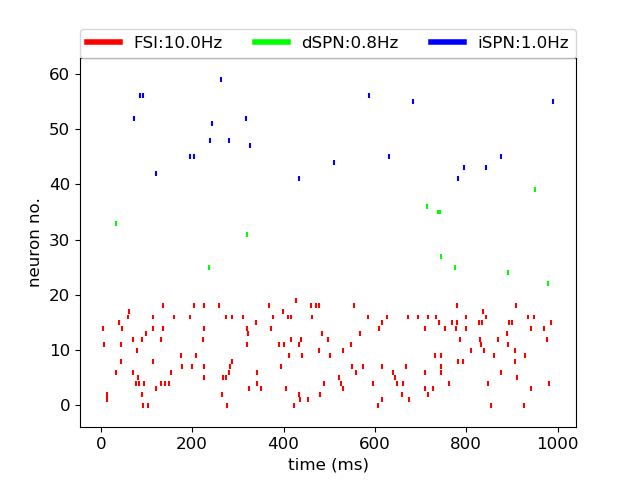

In [29]:
Ix_mean_pop = [0.48,0.31,0.29]
#Ix_mean_pop = [0.15,0,0]
Ix_mean = np.array([Ix_mean_pop[i] for i in Neuron.Tag])
GluIn_mat = np.zeros((Neuron.Tag.size, iterations))
for ind in range(Neuron.Tag.size):
    GluIn_mat[ind, :] = poisson_spikes(Ix_mean[ind], 1000)

%matplotlib notebook
monitor_ind = create_monitorind([20,20,20]) # randomly chosen monitor indices

run_plot(endtime=time, Ix_mat=GluIn_mat, monitor_ind=monitor_ind)
#(monitorSpiketime, monitorSpike, monitorV) = rundynamics(endtime=time, Ix_mat=GluIn_mat, monitor_ind=[0,1,2])

### FSI input effect

In [8]:
Ilist = np.repeat(np.linspace(0.1,0.32,20),1)
nIlist = len(Ilist)
MeanRate = np.zeros((3, nIlist))

for (ind1, Ifsi) in enumerate(Ilist):
    Ix_mean_pop = [Ifsi,0.24,0.24]
    Ix_mean = np.array([Ix_mean_pop[i] for i in Neuron.Tag])
    GluIn_mat = np.zeros((Neuron.Tag.size, iterations))
    for ind2 in range(Neuron.Tag.size):
        GluIn_mat[ind2, :] = poisson_spikes(Ix_mean[ind2], 1000)
    
    Neuron.Wmat = create_Wmat(Population.NN, Population.CP, Population.CW)
    Neuron.V = Neuron.V_R
    rundynamics(endtime=100, Ix_mat=GluIn_mat, monitor_ind=[]);
    rundynamics(endtime=time, Ix_mat=GluIn_mat, monitor_ind=[]);
    MeanRate[:,ind1] = Population.MeanSpikeRate[:]
    

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


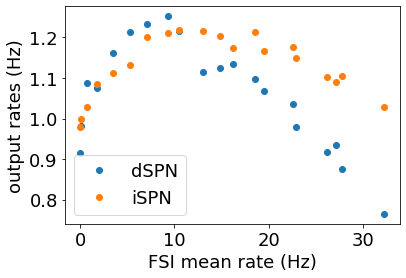

In [16]:
plt.figure()
#plt.plot(Ilist, MeanRate[0,:], label='FSI')
plt.plot(MeanRate[0,:], MeanRate[1,:], 'o', label='dSPN')
plt.plot(MeanRate[0,:], MeanRate[2,:], 'o', label='iSPN')

plt.xlabel('FSI mean rate (Hz)')
plt.ylabel('output rates (Hz)')
plt.legend()
#plt.savefig('FSI_input_effect_2.png')

In [11]:
# binning plot 
nbins = 16
MeanRate2 = np.zeros((3, nbins))
VarRate2  = np.zeros((3, nbins))



x  = MeanRate[0,:]
y  = MeanRate[1,:]
z  = MeanRate[2,:]

n, _ = np.histogram(x, bins=nbins)
MeanRate2[0,:] = (_[1:] + _[:-1])/2

sy, _ = np.histogram(x, bins=nbins, weights=y)
sy2, _ = np.histogram(x, bins=nbins, weights=y*y)
mean = sy / n
std = np.sqrt(sy2/n - mean*mean)
MeanRate2[1,:] = mean
VarRate2[1,:]  = std

sz, _ = np.histogram(x, bins=nbins, weights=z)
sz2, _ = np.histogram(x, bins=nbins, weights=z*z)
mean = sz / n
std = np.sqrt(sz2/n - mean*mean)
MeanRate2[2,:] = mean
VarRate2[2,:]  = std



<IPython.core.display.Javascript object>


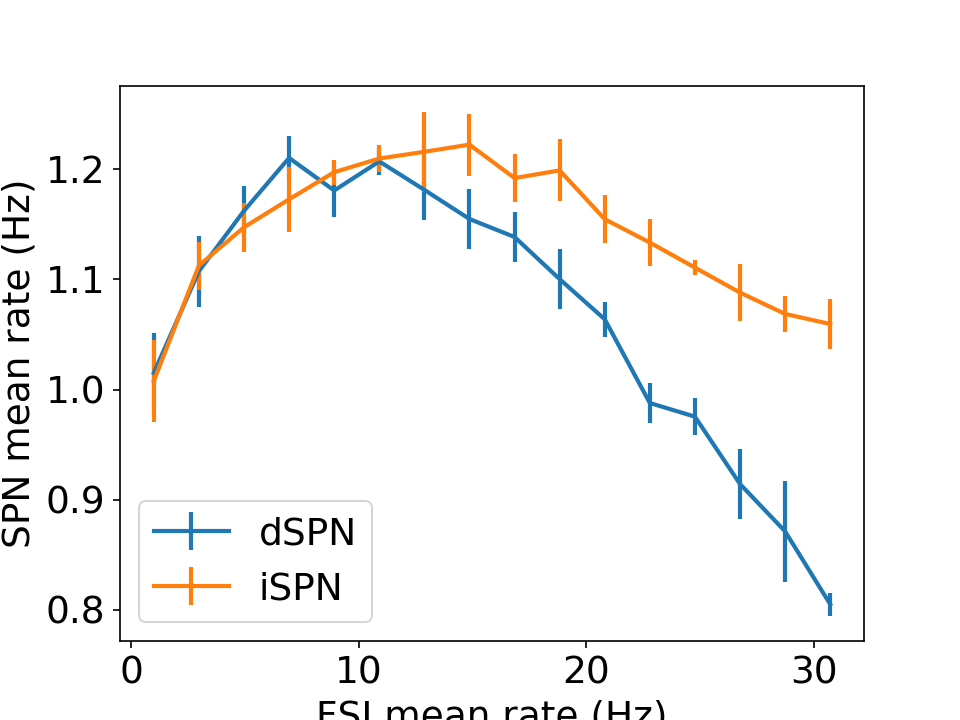

In [12]:
plt.figure()
#plt.plot(Ilist, MeanRate[0,:], label='FSI')
plt.errorbar(MeanRate2[0,:], MeanRate2[1,:], yerr=VarRate2[1,:], label='dSPN', linewidth=2)
plt.errorbar(MeanRate2[0,:], MeanRate2[2,:], yerr=VarRate2[2,:], label='iSPN', linewidth=2)

plt.xlabel('FSI mean rate (Hz)')
plt.ylabel('SPN mean rate (Hz)')
plt.legend()
plt.savefig('FSI_input_effect.svg', dpi=200, bbox_inches='tight')
#plt.savefig('FSI_input_effect_2.png')

## distribution of firing
comparing change in MSN firing between FSI rate 0 and 10
##
FSI rate = 0 -> FSI input = 0
##
FSI rate = 10 Hz -> FSI input ~ 0.18

for vi = -65 mV

for mod = 0.1 & freq=1000 Ix_mean_pop = [0.19,0.3,0.29]

In [9]:
# simulation with FSI_rate=0
Ix_mean_pop = [0,0.24,0.24]    # for vi=-61mV
#Ix_mean_pop = [0,0.3,0.29]     # for vi=-65mV
Ix_mean = np.array([Ix_mean_pop[i] for i in Neuron.Tag])
GluIn_mat_1 = np.zeros((Neuron.Tag.size, iterations), dtype='float32')
for ind2 in range(Neuron.Tag.size):
    GluIn_mat_1[ind2, :] = poisson_spikes(Ix_mean[ind2], 1000)
    
# simulation with FSI_rate=10
Ix_mean_pop = [0.18,0.24,0.24]   # for vi=-61mV
#Ix_mean_pop = [0.19,0.3,0.29]    # for vi=-65mV
Ix_mean = np.array([Ix_mean_pop[i] for i in Neuron.Tag], dtype='float32')
GluIn_mat_2 = np.zeros((Neuron.Tag.size, iterations))
for ind2 in range(Neuron.Tag.size):
    GluIn_mat_2[ind2, :] = poisson_spikes(Ix_mean[ind2], 1000)

In [10]:
SpikeCount_list_1 = np.zeros((Neuron.Tag.size-20))
SpikeCount_list_2 = np.zeros((Neuron.Tag.size-20))


Neuron.Wmat = create_Wmat(Population.NN, Population.CP, Population.CW)

Neuron.V = Neuron.V_R
rundynamics(endtime=100, Ix_mat=GluIn_mat_1, monitor_ind=[]);
rundynamics(endtime=time, Ix_mat=GluIn_mat_1, monitor_ind=[]);
SpikeCount_list_1[:] = Neuron.SpikeCount[20:]


Neuron.V = Neuron.V_R
rundynamics(endtime=100, Ix_mat=GluIn_mat_2, monitor_ind=[]);
rundynamics(endtime=time, Ix_mat=GluIn_mat_2, monitor_ind=[]);
SpikeCount_list_2[:] = Neuron.SpikeCount[20:]    
    

In [8]:
nsim = 1

SpikeCount_list_1 = np.zeros((nsim, Neuron.Tag.size))
SpikeCount_list_2 = np.zeros((nsim, Neuron.Tag.size))


for ind in range(nsim):
    Neuron.Wmat = create_Wmat(Population.NN, Population.CP, Population.CW)
    
    # simulation with FSI_rate=0
    Ix_mean_pop = [0,0.31,0.29]
    Ix_mean = np.array([Ix_mean_pop[i] for i in Neuron.Tag])
    GluIn_mat = np.zeros((Neuron.Tag.size, iterations))
    for ind2 in range(Neuron.Tag.size):
        GluIn_mat[ind2, :] = poisson_spikes(Ix_mean[ind2], 1000)
    
    Neuron.V = Neuron.V_R
    rundynamics(endtime=100, Ix_mat=GluIn_mat, monitor_ind=[]);
    rundynamics(endtime=time, Ix_mat=GluIn_mat, monitor_ind=[]);
    SpikeCount_list_1[ind,:] = Neuron.SpikeCount[:]
    
    # simulation with FSI_rate=10
    Ix_mean_pop = [0.48,0.31,0.29]
    Ix_mean = np.array([Ix_mean_pop[i] for i in Neuron.Tag])
    GluIn_mat = np.zeros((Neuron.Tag.size, iterations))
    for ind2 in range(Neuron.Tag.size):
        GluIn_mat[ind2, :] = poisson_spikes(Ix_mean[ind2], 1000)
    
    Neuron.V = Neuron.V_R
    rundynamics(endtime=100, Ix_mat=GluIn_mat, monitor_ind=[]);
    rundynamics(endtime=time, Ix_mat=GluIn_mat, monitor_ind=[]);
    SpikeCount_list_2[ind,:] = Neuron.SpikeCount[:]
    

(0.20987755102040817, 0.14665656572943989)

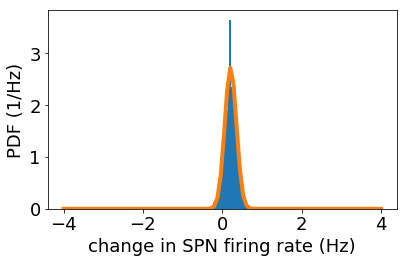

In [15]:
# plotting PDF
rate_change = ((SpikeCount_list_2[20:] - SpikeCount_list_1[20:])/(time/1000)).flatten()
n,x,_ = plt.hist(rate_change, bins=23, density=True);
#bin_centers = 0.5*(x[1:]+x[:-1])
#plt.plot(bin_centers,n)
#plt.xlim([-4,4])
plt.xlabel(r'change in SPN firing rate (Hz)')
plt.ylabel(r'PDF (1/Hz)')

# fit normal function
mu, sigma = scipy.stats.norm.fit(rate_change)
x_fit = np.linspace(-4, 4, num=100)
best_fit_line = scipy.stats.norm.pdf(x_fit, mu, sigma)
plt.plot(x_fit, best_fit_line, linewidth=4)
plt.tight_layout()
#plt.savefig('SPNfiring_change_PDF.svg', dpi=200, bbox_inches='tight')
plt.savefig('SPNfiring_change_PDF_simulation100s_non-monotonicRegime.svg')
mu, sigma

(-1.8910122699386505, 1.253793425096289)

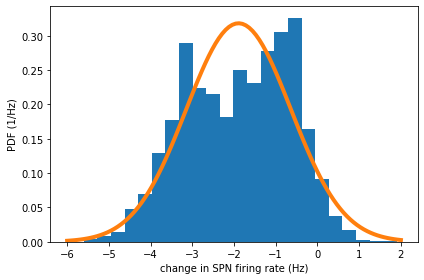

In [16]:
# plotting PDF
rate_change = ((SpikeCount_list_2[0][200:] - SpikeCount_list_1[0][200:])/(time/1000)).flatten()
n,x,_ = plt.hist(rate_change, bins=23, density=True);
#bin_centers = 0.5*(x[1:]+x[:-1])
#plt.plot(bin_centers,n)
#plt.xlim([-4,4])
plt.xlabel(r'change in SPN firing rate (Hz)')
plt.ylabel(r'PDF (1/Hz)')

# fit normal function
mu, sigma = scipy.stats.norm.fit(rate_change)
x_fit = np.linspace(-6, 2, num=100)
best_fit_line = scipy.stats.norm.pdf(x_fit, mu, sigma)
plt.plot(x_fit, best_fit_line, linewidth=4)
plt.tight_layout()
#plt.savefig('SPNfiring_change_PDF.svg', dpi=200, bbox_inches='tight')
plt.savefig('SPNfiring_change_PDF_simulation10s_non-monotonicRegime_10000Neurons.svg')
mu, sigma

In [14]:
SpikeCount_list_1[0][1:10]

array([0., 0., 0., 0., 0., 0., 0., 0., 0.])

(0.9971836734693877, 0.09836431107179103)

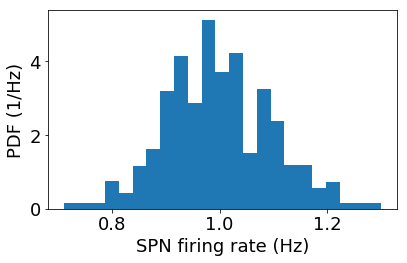

In [16]:
# plotting PDF
rate_change = ((SpikeCount_list_1)/(time/1000)).flatten()
n,x,_ = plt.hist(rate_change, bins=23, density=True);
#bin_centers = 0.5*(x[1:]+x[:-1])
#plt.plot(bin_centers,n)
#plt.xlim([-4,4])
plt.xlabel(r'SPN firing rate (Hz)')
plt.ylabel(r'PDF (1/Hz)')

# fit normal function
mu, sigma = scipy.stats.norm.fit(rate_change)
x_fit = np.linspace(-4, 4, num=100)
best_fit_line = scipy.stats.norm.pdf(x_fit, mu, sigma)
#plt.plot(x_fit, best_fit_line, linewidth=4)
plt.tight_layout()
#plt.savefig('SPNfiring_change_PDF.svg', dpi=200, bbox_inches='tight')
plt.savefig('SPNfiring_PDF_simulation100s_non-monotonicRegime.svg')
mu, sigma

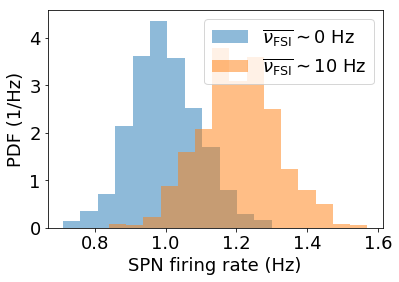

In [17]:
from scipy.optimize import curve_fit
from scipy.special import factorial
from scipy.stats import poisson

def fit_function(k, lamb):
    '''poisson function, parameter lamb is the fit parameter'''
    return poisson.pmf(k, lamb)


data1 = (SpikeCount_list_1/(time/1000)).flatten()
n,x,_ = plt.hist(data1, bins=12, density=True, alpha=0.5, label=r'$\overline{\nu_{\rm FSI}} \sim 0$ Hz');


#bin_centers = 0.5*(x[1:]+x[:-1])
# fit with curve_fit
#parameters, cov_matrix = curve_fit(fit_function, bin_centers, n)
#x_plot = np.linspace(0, 5, num=100)
#plt.plot(x_plot, fit_function(x_plot, *parameters))

data2 = (SpikeCount_list_2/(time/1000)).flatten()
n,x,_ = plt.hist(data2, bins=15, density=True, alpha=0.5, label=r'$\overline{\nu_{\rm FSI}} \sim 10$ Hz');


plt.xlabel(r'SPN firing rate (Hz)')
plt.ylabel(r'PDF (1/Hz)')
plt.legend()
#plt.savefig('SPNfiring_PDF_inhibitoryRegime_100s.svg', dpi=200, bbox_inches='tight')
plt.savefig('SPNfiring_PDF_non-monotonicRegime_100s.svg', dpi=200, bbox_inches='tight')


## Diversity of SPN response to FSI modulation

In [70]:
nsim = 1

SpikeCount_list_1 = np.zeros((nsim, Neuron.Tag.size-20))
SpikeCount_list_2 = np.zeros((nsim, Neuron.Tag.size-20))


for ind in range(nsim):
    Neuron.Wmat = create_Wmat(Population.NN, Population.CP, Population.CW)
    
    # simulation with FSI_rate=0
    Ix_mean_pop = [0,0.24,0.24] # for vGABA = -61 mV
    #Ix_mean_pop = [0,0.29,0.30] # for vGABA = -65 mV
    Ix_mean = np.array([Ix_mean_pop[i] for i in Neuron.Tag])
    GluIn_mat = np.zeros((Neuron.Tag.size, iterations))
    for ind2 in range(Neuron.Tag.size):
        GluIn_mat[ind2, :] = poisson_spikes(Ix_mean[ind2], 1000)
    
    Neuron.V = Neuron.V_R
    rundynamics(endtime=100, Ix_mat=GluIn_mat, monitor_ind=[]);
    rundynamics(endtime=time, Ix_mat=GluIn_mat, monitor_ind=[]);
    SpikeCount_list_1[ind,:] = Neuron.SpikeCount[20:]
    
    # simulation with FSI_rate=10
    Ix_mean_pop = [0.18,0.24,0.24] # for vGABA = -61 mV
    #Ix_mean_pop = [0.18,0.29,0.30] # for vGABA = -65 mV
    Ix_mean = np.array([Ix_mean_pop[i] for i in Neuron.Tag])
    GluIn_mat = np.zeros((Neuron.Tag.size, iterations))
    for ind2 in range(Neuron.Tag.size):
        GluIn_mat[ind2, :] = poisson_spikes(Ix_mean[ind2], 1000)
    
    Neuron.V = Neuron.V_R
    rundynamics(endtime=100, Ix_mat=GluIn_mat, monitor_ind=[]);
    rundynamics(endtime=time, Ix_mat=GluIn_mat, monitor_ind=[]);
    SpikeCount_list_2[ind,:] = Neuron.SpikeCount[20:]
    FSI_spikeCount = Neuron.SpikeCount[:20]

[[ 1.        -0.6606542]
 [-0.6606542  1.       ]]


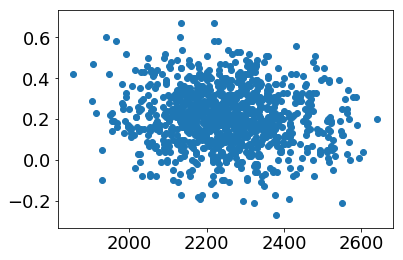

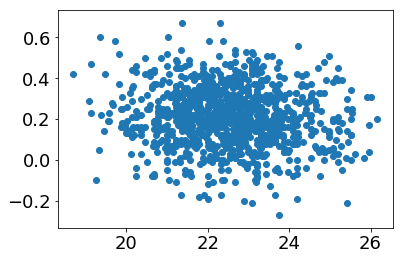

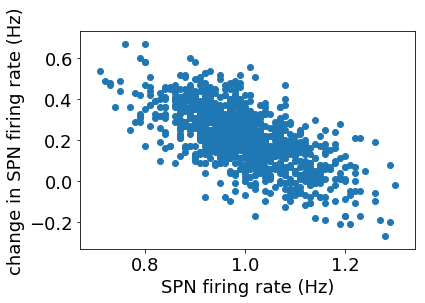

In [19]:
incoming_w = np.sum(Neuron.Wmat[20:, 20:], axis=1)
incoming_rate = np.matmul(Neuron.Wmat[20:, 20:], SpikeCount_list_1.transpose())
#fsi_input = np.matmul(Neuron.Wmat[20:, :20], FSI_spikeCount.transpose())

delta_f = (SpikeCount_list_2 - SpikeCount_list_1)/time*1000

plt.figure()
plt.scatter(incoming_rate, delta_f)

plt.figure()
plt.scatter(incoming_w, delta_f)


#plt.figure()
#plt.scatter(fsi_input, delta_f)
#plt.xlabel(r'FSI input')
#plt.ylabel('change in SPN firing rate (Hz)')

#plt.savefig('SPN_firingChange_scatter_vgaba-61-cor+0.08.svg')
#print(np.corrcoef(fsi_input, delta_f))


plt.figure()
plt.scatter(SpikeCount_list_1/time*1000, delta_f)
plt.xlabel(r'SPN firing rate (Hz)')
plt.ylabel('change in SPN firing rate (Hz)')

plt.savefig('SPN_firingChange_scatter_vgaba-61-cor-0.66.svg')
print(np.corrcoef(SpikeCount_list_1/time*1000, delta_f))